# Multi-class Image Classification
We've just been through a bunch of the following steps with a binary classification problem (pizza vs steak), now we're going to step things up a notch with 10 classes of food (multi-class classification).

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (iverfit it to make sure it works)
5. Evaluate the model
6. Adjust diffrent hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied

### 1. Import and become one with the data

In [1]:
# download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2022-10-26 07:11:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   301MB/s    in 1.6s    

2022-10-26 07:11:57 (301 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [3]:
# Plot the validation and training curves seprately
def plot_loss_curves(history):
    """
    Returns seprate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"])) # how many epochs did we run for?
    
    # Plot loss
    plt.plot(epochs,loss,label="training_loss")
    plt.plot(epochs,val_loss,label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs,accuracy,label="training_accuracy")
    plt.plot(epochs,val_accuracy,label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend();

In [4]:
import os

# Walk through 10 classes of food image data
for dirpath,dirnames,filenames in os.walk("10_food_classes_all_data"):
  print("There are {} directories and {} images in {}".format(len(dirnames),len(filenames),dirpath))

There are 2 directories and 0 images in 10_food_classes_all_data
There are 10 directories and 0 images in 10_food_classes_all_data/test
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_all_data/test/ramen
There are 0 directories and 250 images in 10_food_classes_all_data/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_all_data/test/steak
There are 0 directories and 250 images in 10_food_classes_all_data/test/hamburger
There are 0 directories and 250 images in 10_food_classes_all_data/test/pizza
There are 0 directories and 250 images in 10_food_classes_all_data/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_all_data/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_all_data/test/sushi
There are 0 directories and 250 images in 10_food_classes_all_data/test/grilled_salmon
There are 10 directories and 0 images in 10_fo

In [5]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [6]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (384, 512, 3)


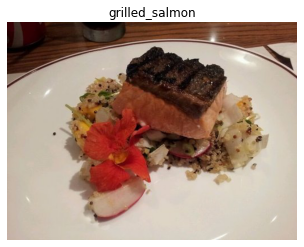

In [7]:
# Visualize, visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                       target_class=random.choice(class_names))

### 2. Preprocess the data (get it ready for a model)

In [8]:
# Create train and test generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load in our image data from our directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224,224),
                                               class_mode="categorical",
                                               batch_size=32)

test_data = train_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224,224),
                                             class_mode="categorical",
                                             batch_size=32)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)
We've been talking a lot about the CNN explainer website... how about we just take their model (also on 10 classes) and use it for our problem...?

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Create a model
model_8 = Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3)),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10,activation="softmax") # change to have 10 output neurons and use the softmax activation function
])

# Compile
model_8.compile(loss="categorical_crossentropy",
               optimizer=Adam(),
               metrics=["accuracy"])

# Fit
history_8 = model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 54s 194ms/step - loss: 2.1620 - accuracy: 0.2141 - val_loss: 1.9842 - val_accuracy: 0.2864
Epoch 2/5
235/235 [==============================] - 45s 192ms/step - loss: 1.9457 - accuracy: 0.3211 - val_loss: 1.8629 - val_accuracy: 0.3496
Epoch 3/5
235/235 [==============================] - 45s 192ms/step - loss: 1.6694 - accuracy: 0.4349 - val_loss: 1.8874 - val_accuracy: 0.3476
Epoch 4/5
235/235 [==============================] - 57s 244ms/step - loss: 1.2095 - accuracy: 0.6059 - val_loss: 2.2209 - val_accuracy: 0.3072
Epoch 5/5
235/235 [==============================] - 46s 195ms/step - loss: 0.6346 - accuracy: 0.8033 - val_loss: 2.9648 - val_accuracy: 0.2904


### 5. Evaluate the model

In [10]:
# Evaluate on the test data
model_8.evaluate(test_data)

79/79 [==============================] - 11s 136ms/step - loss: 2.9648 - accuracy: 0.2904


[2.964794635772705, 0.2903999984264374]

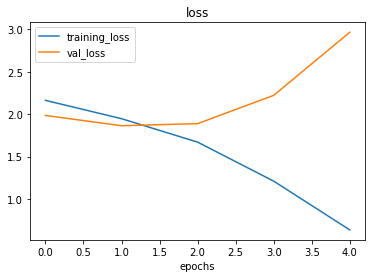

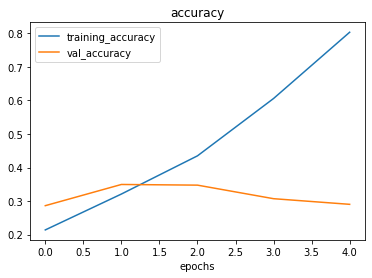

In [11]:
# Check out model loss curves
plot_loss_curves(history_8)

What do these loss curves tell us?

Well... it seems our model is overfitting the training set quite badly... in other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test dataset

### 6. Adjust diffrent hyperparameters and improve the model (try to beat baseline/reduce overfitting)

Due to its performance on the training data, it's clear our model is learning something...

However, it's not generalizing well to unseen data (overfitting).

So, let's try to fix overfitting by...
* **Get more data** - having more data gives a model more opportunity to learn diverse patterns...
* **Simplify the model** - if our current model is overfitting the data, it may be too complicated of a model, one way to simplify a model is to: reduce layer or reduce hidden units in layers
* **Use data augmentation** - data augmentation manipulated the training data in such a way to add diversity to it (without altering the original data)
* **Use transfer learning** - transfer learning leverages the patterns another model has learned on similar data to your own and allows you to use those patterns on your own dataset

In [12]:
# How about we try to simplify the model first?
# Let's try to remove 2 convolutional layers...
model_9 = Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3)),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10,activation="softmax")
])

model_9.compile(loss="categorical_crossentropy",
               optimizer=Adam(),
               metrics=["accuracy"])

In [13]:
history_9 = model_9.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 44s 185ms/step - loss: 2.1361 - accuracy: 0.2280 - val_loss: 2.0328 - val_accuracy: 0.2516
Epoch 2/5
235/235 [==============================] - 43s 183ms/step - loss: 1.7833 - accuracy: 0.3949 - val_loss: 1.9378 - val_accuracy: 0.3260
Epoch 3/5
235/235 [==============================] - 44s 187ms/step - loss: 1.2728 - accuracy: 0.5905 - val_loss: 2.0999 - val_accuracy: 0.3340
Epoch 4/5
235/235 [==============================] - 43s 184ms/step - loss: 0.6906 - accuracy: 0.7925 - val_loss: 2.5574 - val_accuracy: 0.2928
Epoch 5/5
235/235 [==============================] - 43s 184ms/step - loss: 0.3316 - accuracy: 0.9133 - val_loss: 3.1549 - val_accuracy: 0.2844


Looks like our "simplifying the model" experiment didn't work... the accuracy went down and overfitting continued...

How about we try data augmentation??

### Trying to reduce overfitting with data augmentation
Let's try and improve our model's results by using augmented training data...

Ideally, we want to:

* Reducr overfitting (get the train and validation loss curves closer)
* Improve validation accuracy

In [14]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                            rotation_range=0.2,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True)

# Import data and augment it from training directory
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224,224),
                                                                  batch_size=32,
                                                                  class_mode="categorical")

Found 7500 images belonging to 10 classes.


In [15]:
# Let's create another model but this time we'll fit it on the augmented training data
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model (using the same setup as previous models)
model_10.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [16]:
#  Fit the model 
history_10 = model_10.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 110s 468ms/step - loss: 2.3002 - accuracy: 0.0953 - val_loss: 2.3026 - val_accuracy: 0.0976
Epoch 2/5
235/235 [==============================] - 109s 464ms/step - loss: 2.3031 - accuracy: 0.0995 - val_loss: 2.3020 - val_accuracy: 0.1136
Epoch 3/5
235/235 [==============================] - 111s 472ms/step - loss: 2.2754 - accuracy: 0.1420 - val_loss: 2.1348 - val_accuracy: 0.2340
Epoch 4/5
235/235 [==============================] - 109s 463ms/step - loss: 2.1646 - accuracy: 0.2069 - val_loss: 2.0672 - val_accuracy: 0.2776
Epoch 5/5
235/235 [==============================] - 110s 468ms/step - loss: 2.1151 - accuracy: 0.2404 - val_loss: 1.9961 - val_accuracy: 0.3124


In [17]:
model_8.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 2.9648 - accuracy: 0.2904


[2.9647953510284424, 0.2903999984264374]

In [18]:
model_10.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 1.9961 - accuracy: 0.3124


[1.9961496591567993, 0.3124000132083893]

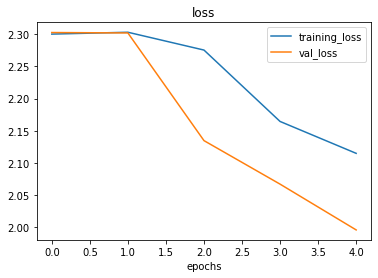

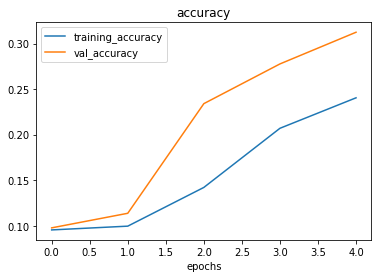

In [19]:
plot_loss_curves(history_10)

Woah! That looks much better, the loss curves are much closer to each other than the baseline model and they look like they're heading in the right direction (certainly not the wrong direction) so if we were to train for longer, we might see further improvements.

### 7. Repeat until satisfied

We could keep going here... continually trying to bring out loss curves closer together and trying to improve the validation/test accuracy.

How?

By running lots of experiments, namely:

* restructuring our model's architecture (increasing layers/hidden units)
* adjust the learning rate
* try different methods of data augmentation (adjust the hyperparameters in our ImageDataGenerator instance)
* training for longer (eg. 10 epochs instead of 5 epochs)
* try **transfer learning**

### Making a prediction with our trained model

Let's use our trained model to make some predictions on our own custom images!

In [20]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [21]:
# Download custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

--2022-10-26 07:38:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg’

03-hamburger.jpeg   100%[===================>]   3.40M  --.-KB/s    in 0.07s   

2022-10-26 07:38:53 (50.9 MB/s) - ‘03-hamburger.jpeg’ saved [3564285/3564285]

--2022-10-26 07:38:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [22]:
#Create a function to import and image and resize it to be able to be used with our model
def load_and_prep_image(file_name, img_shape=224): 
  """ 
    Reads an image from filename, turns it into a tensor and reshapes it to (img_shape,img_shape,colour_channels)
  """

  # Read in the image
  img = tf.io.read_file(file_name)
  # Decode the read file into a tesor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img,size=[img_shape,img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [23]:
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model,filename,class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model
    and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img,axis=0))
    
    # Add in logic for multi-class
    if len(pred[0]) > 1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = class_names[int(tf.round(pred[0]))]
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title("Prediction: {}".format(pred_class))
    plt.axis(False);

1/1 [==============================] - 0s 16ms/step


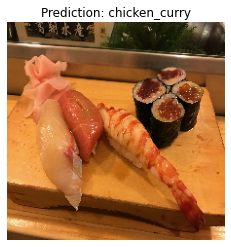

In [25]:
# Make a prediction using model_10
pred_and_plot(model=model_10,
             filename="03-sushi.jpeg",
             class_names=class_names)

Looks like our model didn't perform very well on our custom images but this is because it only achieved ~39% accuracy on the test data. So we can expect it to function quite poorly on other unseen data.

### Saving and loading our model

In [26]:
# Save a model
model_10.save("saved_trained_model_10")

In [27]:
# Load in a trained model and evaluate it
loaded_model_10 = tf.keras.models.load_model("saved_trained_model_10")

In [28]:
loaded_model_10.evaluate(test_data)

79/79 [==============================] - 12s 151ms/step - loss: 1.9961 - accuracy: 0.3124


[1.9961490631103516, 0.3124000132083893]

In [29]:
# Compare out loaded model to our existing model
model_10.evaluate(test_data)

79/79 [==============================] - 11s 137ms/step - loss: 1.9961 - accuracy: 0.3124


[1.9961491823196411, 0.3124000132083893]